In [5]:
from pathlib import Path 
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
from scipy import stats
import os 

In [6]:
# import numpy as np
# import pandas as pd
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

# def read_data(file_paths):
#     """
#     Read data from multiple files and concatenate durations.
    
#     Args:
#         file_paths: List of file paths to read data from
        
#     Returns:
#         durations: Concatenated array of duration values
#     """
#     all_durations = []
    
#     for file_path in file_paths:
#         data = pd.read_csv(file_path, sep='\t', header=None, names=['timestamps', 'durations'])
#         all_durations.append(data['durations'].values)
    
#     return np.concatenate(all_durations)

# def generate_bin(durations, interval):
#     """
#     Bin durations into intervals and calculate density.
    
#     Args:
#         durations: List of duration values
#         interval: Size of each bin
        
#     Returns:
#         bin_centers: Centers of each bin
#         bin_density: Density count in each bin
#     """
#     max_duration = np.max(durations)
#     num_bins = int(np.ceil(max_duration / interval))
#     bins = np.linspace(0, num_bins * interval, num_bins + 1)
    
#     hist, bin_edges = np.histogram(durations, bins=bins)
#     bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
#     bin_density = hist / (len(durations) * interval)
    
#     return bin_centers, bin_density

# def kde_traces(durations, interval, name=None):
#     """
#     Generate histogram and density estimate traces.
    
#     Args:
#         durations: List of duration values
#         interval: Size of each bin
#         name: Legend group name (defaults to interval+μs if None)
    
#     Returns:
#         List of plotly traces for histogram and density
#     """
#     bin_centers, bin_density = generate_bin(durations, interval)
    
#     # Set default legend group name if not provided
#     if name is None:
#         name = f"{interval}μs"
    
#     # Generate a consistent color for both traces
#     color = f"hsl({hash(name) % 360}, 70%, 50%)"
    
#     # Create histogram trace
#     histogram_trace = go.Histogram(
#         x=durations,
#         xbins=dict(
#             start=0,
#             end=np.max(durations),
#             size=interval
#         ),
#         histnorm='probability density',
#         name=f"{name} histogram",
#         legendgroup=name,
#         opacity=0.7,
#         marker_color=color
#     )
    
#     # Create density trace
#     density_trace = go.Scatter(
#         x=bin_centers,
#         y=bin_density,
#         mode='markers+lines',
#         name=f"{name} density",
#         legendgroup=name,
#         marker=dict(size=8, color=color),
#         line=dict(color=color)
#     )
    
#     return [density_trace]

# traces = []
# for i in [0.05, 0.1, 0.2, 0.5, 1]: 
#     traces.extend(kde_traces(durations, i))

# fig = go.Figure(data=traces)
# fig.show()

In [7]:
def read_data(file_paths, includes_amplitude=False):
    """
    Read data from multiple files and concatenate durations.
    
    Args:
        file_paths: List of file paths to read data from
        includes_amplitude: If True, expect three columns (timestamps, durations, amplitudes)
        
    Returns:
        durations: Concatenated array of duration values if includes_amplitude=False
        (durations, amplitudes): Tuple of concatenated arrays if includes_amplitude=True
    """
    all_durations = []
    all_amplitudes = []
    
    for file_path in file_paths:
        if includes_amplitude:
            data = pd.read_csv(file_path, sep='\t', header=None, 
                              names=['timestamps', 'durations', 'amplitudes'])
            all_durations.append(data['durations'].values)
            all_amplitudes.append(data['amplitudes'].values)
        else:
            data = pd.read_csv(file_path, sep='\t', header=None, 
                              names=['timestamps', 'durations'])
            all_durations.append(data['durations'].values)
    
    if includes_amplitude:
        return np.concatenate(all_durations), np.concatenate(all_amplitudes)
    else:
        return np.concatenate(all_durations)

def kde_sample(durations, kde_num_samples, normalized=True):
    """
    Create a KDE sample with equally spaced points.
    
    Parameters:
    -----------
    durations : array-like
        The data points to analyze
    kde_num_samples : int
        Number of equally spaced sample points to generate
    normalized : bool, default=True
        If True, normalize the bin counts so that the sum of bin_width * bin_density[j] equals 1
    
    Returns:
    --------
    bin_centers : array
        The centers of each bin (equally spaced points)
    bin_counts : array
        The count/density at each bin center
    """
    min_val = np.min(durations)
    max_val = np.max(durations)
    
    # Calculate interval width to get kde_num_samples points
    interval_width = (max_val - min_val) / (kde_num_samples - 1)
    
    # Create equally spaced points
    bin_centers = np.linspace(min_val, max_val, kde_num_samples)
    
    # Create bin edges (bin_centers are the LHS of bins)
    bin_edges = np.append(bin_centers, bin_centers[-1] + interval_width)
    
    # Count occurrences in each bin
    bin_counts, _ = np.histogram(durations, bins=bin_edges, density=False)
    
    # Convert counts to density
    bin_counts = bin_counts / (len(durations) * interval_width)
    
    # Normalize if requested
    if normalized:
        # Ensure the sum of bin_width * bin_density equals 1
        normalization_factor = np.sum(bin_counts * interval_width)
        if normalization_factor > 0:  # Avoid division by zero
            bin_counts = bin_counts / normalization_factor
    
    return bin_centers, bin_counts

In [8]:
# data_files = [Path('../raw_data/m_0306_0.txt'), Path('../raw_data/m_0306_1.txt')]
data_files = [Path('../raw_data/lifetimeMass_data.txt')]
if len(data_files) == 1:
    amplitudes, durations = read_data(data_files, includes_amplitude=True)
else:
    durations = read_data(data_files)
print(len(durations), 'data points')

50250 data points


In [52]:
def analyze_lifetime_data(durations, amplitudes=None, exp_cutoff=0.99, early_cutoff=1, kde_samples=200):
    cutoff = stats.expon.ppf(exp_cutoff, scale=2.2)
    # print(cutoff)
    # Process duration data
    bin_centers, bin_density = kde_sample(durations, kde_samples, normalized=True)
    grid_interval = bin_centers[1] - bin_centers[0]
    bin_centers, bin_density = bin_centers[:-1], bin_density[:-1]
    
    # Process amplitude data if provided
    amp_bin_centers, amp_bin_density = None, None
    qt_maxamplitude = None
    if amplitudes is not None:
        chosen_amplitudes = amplitudes[(durations <= cutoff) & (durations >= 1)]
        amp_bin_centers, amp_bin_density = kde_sample(chosen_amplitudes, 50, normalized=True)
        qt_maxamplitude = np.quantile(chosen_amplitudes, 0.999)
    
    # Calculate background and correct density
    background_density = bin_density[bin_centers > cutoff].mean()
    new_bin_centers = bin_centers[bin_centers <= cutoff]
    new_bin_density = bin_density[bin_centers <= cutoff] - background_density
    # The proportion of background counts in the total data
    background_proportion = background_density * len(bin_centers) * grid_interval
    print(background_proportion)
    
    # Normalize the new bin density 
    new_bin_density[new_bin_density < 0] = 1e-8
    new_bin_density /= grid_interval * new_bin_density.sum()
    
    # Final data for fitting
    final_bin_centers = new_bin_centers[new_bin_centers > early_cutoff]
    final_bin_density = new_bin_density[new_bin_centers > early_cutoff]
    
    # Linear regression on log of density
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        final_bin_centers, np.log(final_bin_density))
    
    # Return all results in a dictionary
    return {
        'bin_centers': bin_centers,
        'bin_density': bin_density,
        'amp_bin_centers': amp_bin_centers,
        'amp_bin_density': amp_bin_density,
        'qt_maxamplitude': qt_maxamplitude,
        'background_density': background_density,
        'new_bin_centers': new_bin_centers,
        'new_bin_density': new_bin_density,
        'final_bin_centers': final_bin_centers,
        'final_bin_density': final_bin_density,
        'slope': slope,
        'lifetime': 1/slope, 
        # 'background_proportion': background_proportion,
        'intercept': intercept,
        'r_value': r_value,
        'p_value': p_value,
        'std_err': std_err,
        'cutoff': cutoff
    }

results = analyze_lifetime_data(
    durations, amplitudes, exp_cutoff=0.95, early_cutoff=1, kde_samples=200)
results

0.31818561328694867


{'bin_centers': array([ 0.        ,  0.10030151,  0.20060302,  0.30090452,  0.40120603,
         0.50150754,  0.60180905,  0.70211055,  0.80241206,  0.90271357,
         1.00301508,  1.10331658,  1.20361809,  1.3039196 ,  1.40422111,
         1.50452261,  1.60482412,  1.70512563,  1.80542714,  1.90572864,
         2.00603015,  2.10633166,  2.20663317,  2.30693467,  2.40723618,
         2.50753769,  2.6078392 ,  2.7081407 ,  2.80844221,  2.90874372,
         3.00904523,  3.10934673,  3.20964824,  3.30994975,  3.41025126,
         3.51055276,  3.61085427,  3.71115578,  3.81145729,  3.91175879,
         4.0120603 ,  4.11236181,  4.21266332,  4.31296482,  4.41326633,
         4.51356784,  4.61386935,  4.71417085,  4.81447236,  4.91477387,
         5.01507538,  5.11537688,  5.21567839,  5.3159799 ,  5.41628141,
         5.51658291,  5.61688442,  5.71718593,  5.81748744,  5.91778894,
         6.01809045,  6.11839196,  6.21869347,  6.31899497,  6.41929648,
         6.51959799,  6.6198995 ,  6

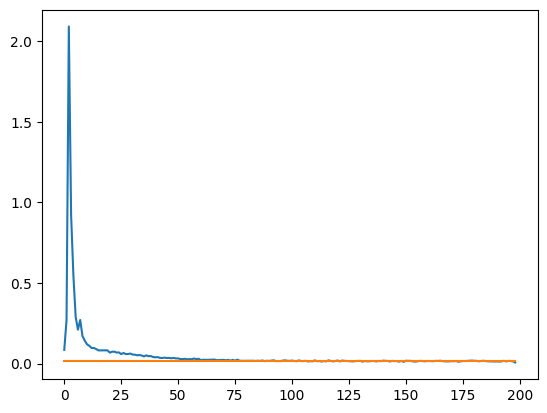

In [ ]:
plt.plot(results['bin_density'])
plt.plot(results['background_density'] + np.zeros_like(results['bin_density']))
plt.show()

Heatmap 1: Fixing exp_cutoff at 0.99


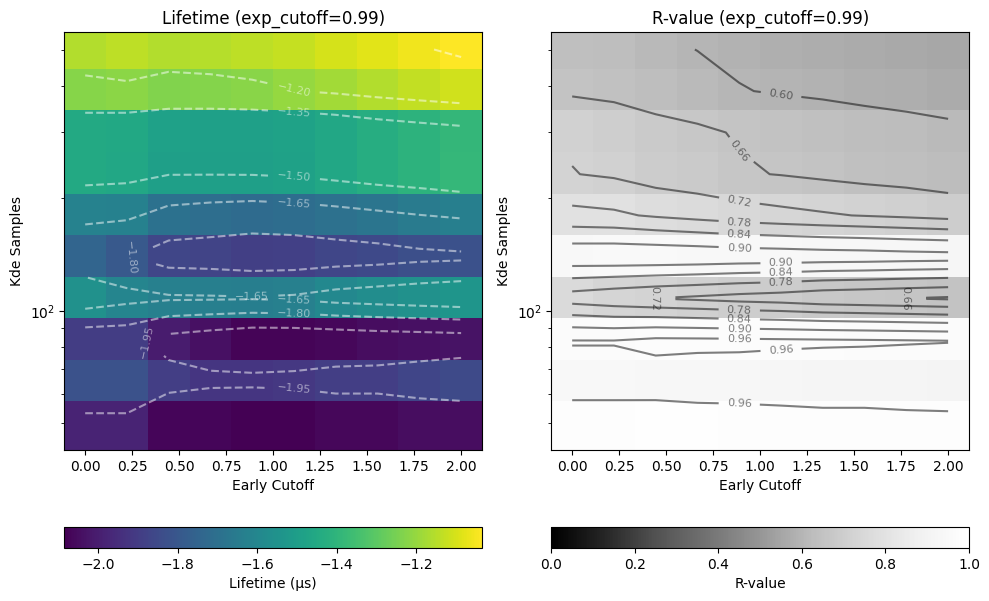

Heatmap 2: Fixing early_cutoff at 1


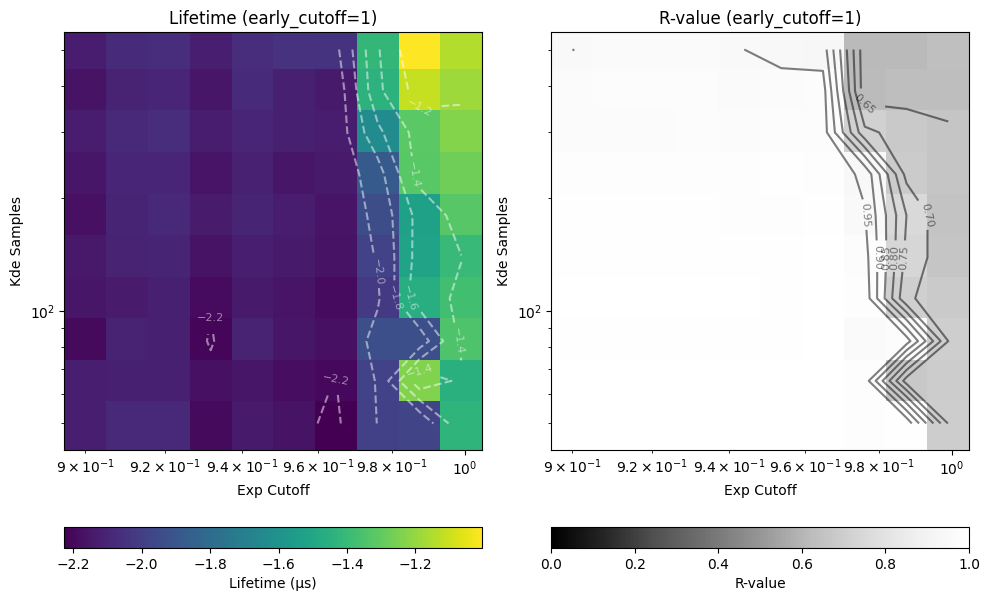

Heatmap 3: Fixing kde_samples at 200


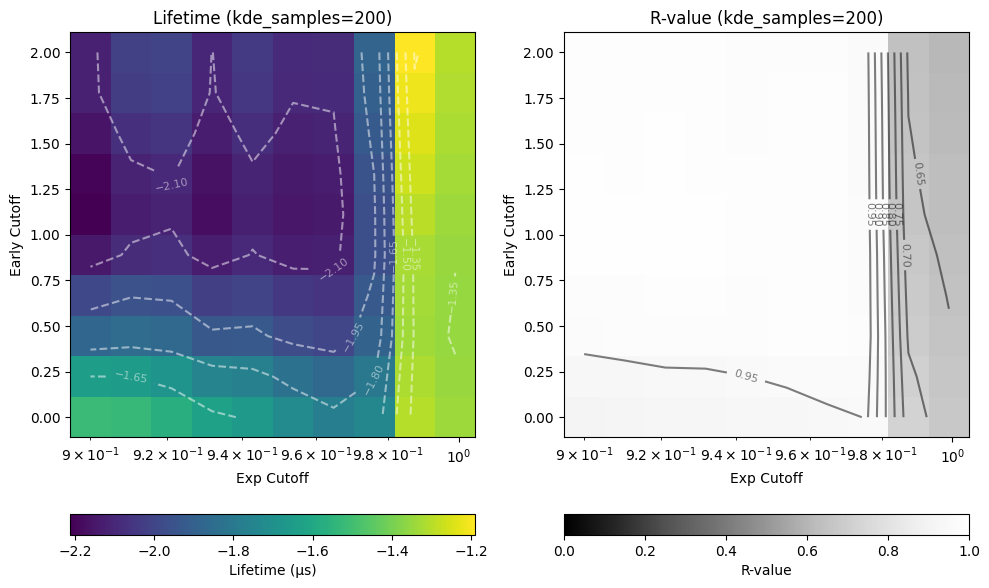

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Create parameter grids
exp_cutoffs = np.logspace(np.log10(0.9), np.log10(0.999), 10)  # Log-scale for exp_cutoff
early_cutoffs = np.linspace(0, 2, 10)  # Linear scale for early_cutoff
kde_samples_values = np.round(np.logspace(np.log10(50), np.log10(500), 10)).astype(int)  # Log-scale for kde_samples

# Function to create a heatmap with two varying parameters
def plot_lifetime_heatmap(fixed_param_name, fixed_param_value):
    """
    Create a heatmap of lifetime as a function of two varying parameters,
    with the third parameter fixed.
    
    Parameters
    ----------
    fixed_param_name : str
        Name of the parameter to fix ('exp_cutoff', 'early_cutoff', or 'kde_samples')
    fixed_param_value : float
        Value to fix the parameter at
    """
    if fixed_param_name == 'exp_cutoff':
        param1_name, param1_values = 'early_cutoff', early_cutoffs
        param2_name, param2_values = 'kde_samples', kde_samples_values
        title = f'Lifetime vs Early Cutoff and KDE Samples (Exp Cutoff = {fixed_param_value})'
    elif fixed_param_name == 'early_cutoff':
        param1_name, param1_values = 'exp_cutoff', exp_cutoffs
        param2_name, param2_values = 'kde_samples', kde_samples_values
        title = f'Lifetime vs Exp Cutoff and KDE Samples (Early Cutoff = {fixed_param_value})'
    else:  # fixed_param_name == 'kde_samples'
        param1_name, param1_values = 'exp_cutoff', exp_cutoffs
        param2_name, param2_values = 'early_cutoff', early_cutoffs
        title = f'Lifetime vs Exp Cutoff and Early Cutoff (KDE Samples = {fixed_param_value})'
    
    # Create meshgrid for the two varying parameters
    X, Y = np.meshgrid(param1_values, param2_values)
    Z_lifetime = np.zeros_like(X)
    Z_r_value = np.zeros_like(X)
    
    # Calculate lifetime and r_value for each parameter combination
    for i in range(len(param2_values)):
        for j in range(len(param1_values)):
            kwargs = {
                'exp_cutoff': fixed_param_value if fixed_param_name == 'exp_cutoff' else param1_values[j],
                'early_cutoff': fixed_param_value if fixed_param_name == 'early_cutoff' else (param1_values[j] if param1_name == 'early_cutoff' else param2_values[i]),
                'kde_samples': fixed_param_value if fixed_param_name == 'kde_samples' else (param1_values[j] if param1_name == 'kde_samples' else param2_values[i])
            }
            result = analyze_lifetime_data(durations, amplitudes, **kwargs)
            Z_lifetime[i, j] = result['lifetime']
            Z_r_value[i, j] = abs(result['r_value'])  # Use absolute value to ensure 0 to 1 range
    
    # Create horizontally-juxtaposed plots with square aspect ratio
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
    
    # Left plot: Lifetime
    lifetime_plot = ax1.pcolormesh(X, Y, Z_lifetime, cmap=cm.viridis, shading='auto')
    cbar1 = fig.colorbar(lifetime_plot, ax=ax1, label='Lifetime (μs)', orientation='horizontal', pad=0.1)
    
    # Set log scale for axes if the parameter is using log scale
    if param1_name == 'exp_cutoff' or param1_name == 'kde_samples':
        ax1.set_xscale('log')
    if param2_name == 'exp_cutoff' or param2_name == 'kde_samples':
        ax1.set_yscale('log')
        
    ax1.set_xlabel(param1_name.replace('_', ' ').title())
    ax1.set_ylabel(param2_name.replace('_', ' ').title())
    ax1.set_title(f'Lifetime ({fixed_param_name}={fixed_param_value})')
    
    # Force square aspect ratio
    ax1.set_box_aspect(1)
    
    # Add contour lines for better visualization
    contour1 = ax1.contour(X, Y, Z_lifetime, colors='white', alpha=0.5)
    ax1.clabel(contour1, inline=True, fontsize=8)
    
    # Right plot: R-value
    r_value_plot = ax2.pcolormesh(X, Y, Z_r_value, cmap='Greys_r', vmin=0, vmax=1, shading='auto')
    cbar2 = fig.colorbar(r_value_plot, ax=ax2, label='R-value', orientation='horizontal', pad=0.1)
    
    # Set log scale for axes if the parameter is using log scale
    if param1_name == 'exp_cutoff' or param1_name == 'kde_samples':
        ax2.set_xscale('log')
    if param2_name == 'exp_cutoff' or param2_name == 'kde_samples':
        ax2.set_yscale('log')
        
    ax2.set_xlabel(param1_name.replace('_', ' ').title())
    ax2.set_ylabel(param2_name.replace('_', ' ').title())
    ax2.set_title(f'R-value ({fixed_param_name}={fixed_param_value})')
    
    # Force square aspect ratio
    ax2.set_box_aspect(1)
    
    # Add contour lines for better visualization
    contour2 = ax2.contour(X, Y, Z_r_value, colors='black', alpha=0.5)
    ax2.clabel(contour2, inline=True, fontsize=8)
    
    plt.tight_layout()
    plt.show()

# Create three heatmaps, one for fixing each default parameter
print("Heatmap 1: Fixing exp_cutoff at 0.99")
plot_lifetime_heatmap('exp_cutoff', 0.99)

print("Heatmap 2: Fixing early_cutoff at 1")
plot_lifetime_heatmap('early_cutoff', 1)

print("Heatmap 3: Fixing kde_samples at 200")
plot_lifetime_heatmap('kde_samples', 200)

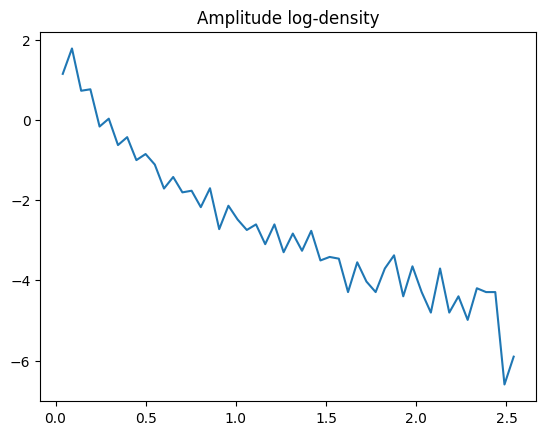

Inv-slope: -2.1390, R-squared: 0.9676


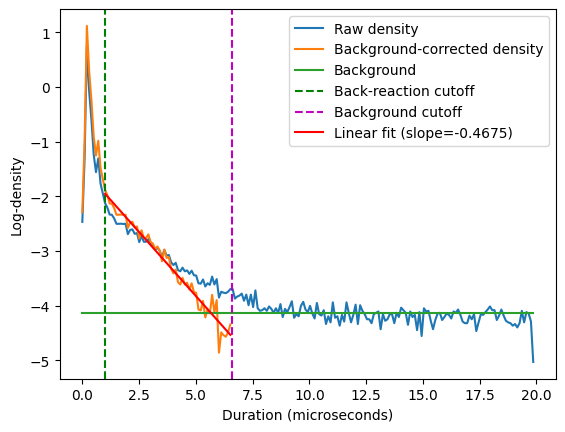

In [19]:
def plot_results(results):
    """
    Plot the results from analyze_lifetime_data.
    
    Parameters
    ----------
    results : dict
        Dictionary containing analysis results
    """
    # Plot amplitude density if available
    if results['amp_bin_centers'] is not None and results['amp_bin_density'] is not None:
        plt.title('Amplitude log-density')
        plt.plot(results['amp_bin_centers'], np.log(results['amp_bin_density']))
        plt.show()
    
    # Plot duration densities and fit
    plt.plot(results['bin_centers'], np.log(results['bin_density']), label='Raw density')
    plt.plot(results['new_bin_centers'], np.log(results['new_bin_density']), 
                label='Background-corrected density')
    plt.plot(results['bin_centers'], 
                np.log(np.zeros_like(results['bin_centers']) + results['background_density']), 
                label='Background')
    plt.axvline(x=1, color='g', linestyle='--', label='Back-reaction cutoff')
    plt.axvline(x=results['cutoff'], color='m', linestyle='--', label='Background cutoff')
    plt.plot(results['final_bin_centers'], 
                results['intercept'] + results['slope'] * results['final_bin_centers'], 'r-', 
                label=f'Linear fit (slope={results["slope"]:.4f})')
    print(f"Inv-slope: {1/results['slope']:.4f}, R-squared: {results['r_value']**2:.4f}")
    
    plt.xlabel('Duration (microseconds)')
    plt.ylabel('Log-density')
    plt.legend()
    plt.show()
    
plot_results(results)

14341 50250


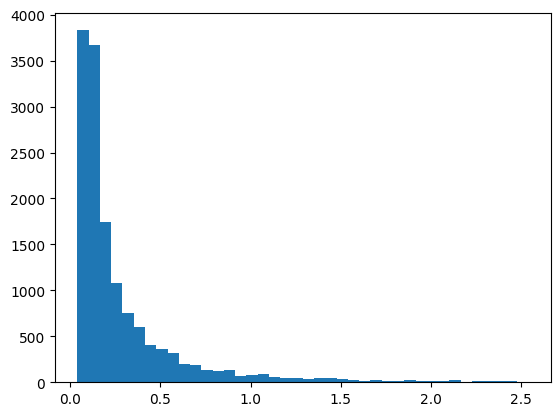

In [41]:
selected_amplitudes = amplitudes[(durations <= results['cutoff']) & (durations >= 1)]
print(len(selected_amplitudes), len(amplitudes))
plt.hist(selected_amplitudes, bins=40) 
# plt.ylim(0, 500)
plt.show()

In [ ]:
selected_amplitudes = amplitudes[(durations <= results['cutoff']) & (durations >= 1)]

# Bootstrap 99th percentile with 10,000 samples
n_boot = 10000
from tqdm import tqdm
boot_percentiles = np.array([
    np.percentile(np.random.choice(selected_amplitudes, size=len(selected_amplitudes), replace=True), 98.5)
    for _ in tqdm(range(n_boot))
])

# Plot distribution of bootstrapped percentiles
plt.figure(figsize=(10, 6))
plt.hist(boot_percentiles, bins=50, density=True, alpha=0.7)
plt.title('Bootstrapped Distribution of 99th Percentile Amplitudes')
plt.xlabel('Amplitude Value')
plt.ylabel('Density')
plt.show()

# Calculate and print 95% confidence interval
ci_low, ci_high = np.percentile(boot_percentiles, [2.5, 97.5])
print(f"95% Confidence Interval: [{ci_low:.2f}, {ci_high:.2f}]")

 79%|███████▊  | 7852/10000 [00:02<00:00, 3667.81it/s]